# Comparing journey times returned by Mapzen's OSRM and [Valhalla](https://mapzen.com/projects/valhalla) instances

In [45]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 12)
mpl.rcParams['savefig.dpi'] = 200

In [ ]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Helvetica']})

Use LaTeX (skip the next cell if you don't have it)

In [94]:
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\usepackage{sfmath}'})

The journey times were retrieved by calling Mapzen's [OSRM](https://github.com/urschrei/Geopython/blob/6b504b857a736c3b011755ce44821cefdefd70bf/isochrone.ipynb) and [Valhalla](https://github.com/urschrei/Geopython/blob/master/isochrone.ipynb) instances, respectively.  
Calls to OSRM used `viaroute=bicycle`, calls to Valhalla used `{costing: bicycle}`  
No costing options were set for Valhalla.  

The journey times were retrieved from `['route_summary']['total_time']` for OSRM  
The journey times were retrieved from `['trip']['summary']['time']` for Valhalla

In [11]:
osrm_station_data = pd.read_csv('stations_travel_time.csv', index_col=0)
valhalla_station_data = pd.read_csv('stations_travel_time_valhalla.csv', index_col=0)

####Journey origin is:

-0.12203999999842599, 51.500829999995766 (lon, lat)  
27054.81221603953, 25108.754540393566 (projected coordinates)  

`centroid_distance` is calculated using pythagoras' theorem  
`travel_time` is calculated in minutes (returned journey time / 60)

In [4]:
osrm_station_data.head()

,lat,lon,name,projected_lon,projected_lat,centroid_distance,travel_time
0,51.529163,-0.109971,"River Street , Clerkenwell",27811.388447,28282.270369,2968.313250,21.654045
1,51.499607,-0.197574,"Phillimore Gardens, Kensington",21813.727944,24840.827966,3969.751444,32.328405
2,51.521284,-0.084606,"Christopher Street, Liverpool Street",29594.342661,27451.475186,4503.092527,22.447410
3,51.530059,-0.120974,"St. Chad's Street, King's Cross",27045.344113,28362.269051,2336.626317,23.625436
4,51.493130,-0.156876,"Sedding Street, Sloane Square",24657.683764,24190.679446,2899.434664,14.609929


Valhalla returned more valid journeys than OSRM, so we'll use a left join to keep only those returned by both 

In [79]:
merged = pd.merge(
    osrm_station_data,
    valhalla_station_data[['name', 'travel_time']],
    how='left',
    on=['name'],
    suffixes=['_osrm', '_valhalla']).dropna()

# 0 travel time makes no sense; make it 1 minute
merged.loc[merged['travel_time_osrm'] <= 1., 'travel_time_osrm'] = 1.
merged['duration_difference'] = merged['travel_time_osrm'] - merged['travel_time_valhalla']
# this is going to produce huge outliers, so maybe not that useful
merged['percentage_speedup'] = 100 - ((merged['travel_time_valhalla'] / merged['travel_time_osrm']) * 100)

In [80]:
merged.head()

,lat,lon,name,projected_lon,projected_lat,centroid_distance,travel_time_osrm,travel_time_valhalla,duration_difference,percentage_speedup
0,51.529163,-0.109971,"River Street , Clerkenwell",27811.388447,28282.270369,2968.313250,21.654045,17.133333,4.520712,20.876985
1,51.499607,-0.197574,"Phillimore Gardens, Kensington",21813.727944,24840.827966,3969.751444,32.328405,17.333333,14.995072,46.383580
2,51.521284,-0.084606,"Christopher Street, Liverpool Street",29594.342661,27451.475186,4503.092527,22.447410,19.300000,3.147410,14.021260
3,51.530059,-0.120974,"St. Chad's Street, King's Cross",27045.344113,28362.269051,2336.626317,23.625436,16.233333,7.392102,31.288745
4,51.493130,-0.156876,"Sedding Street, Sloane Square",24657.683764,24190.679446,2899.434664,14.609929,10.950000,3.659929,25.050971


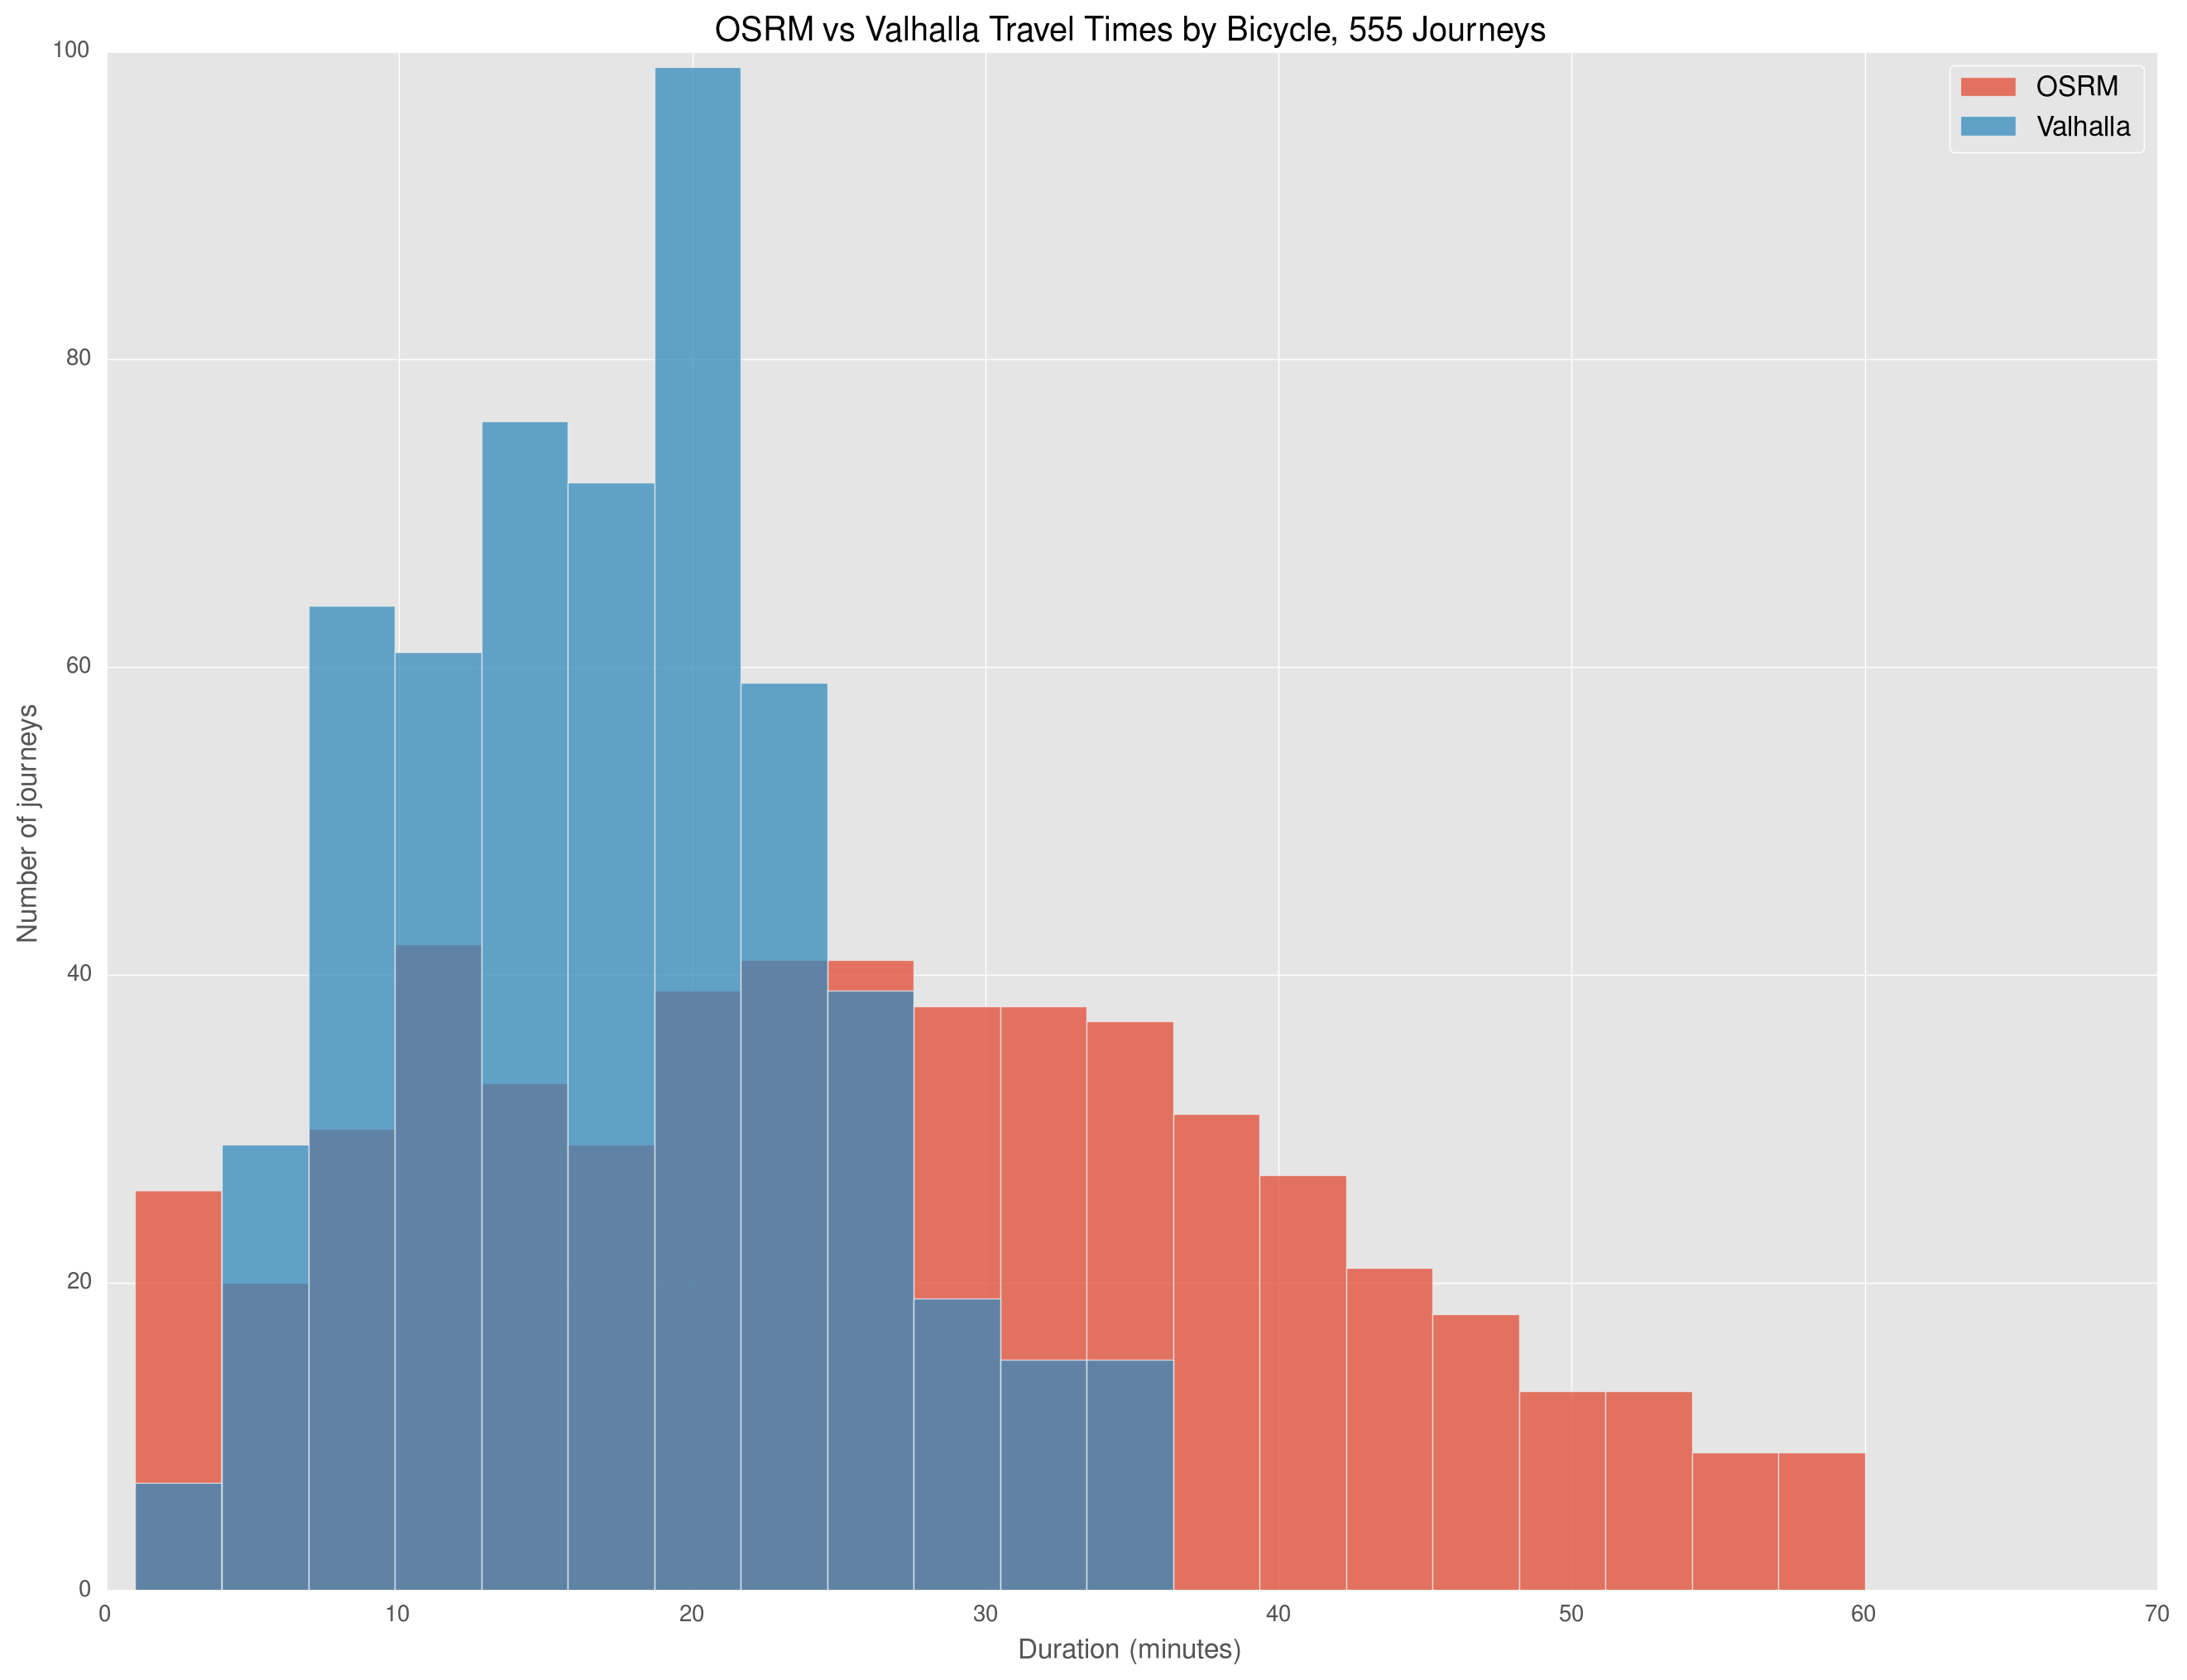

In [96]:
plt.clf()

ax = merged[['travel_time_osrm', 'travel_time_valhalla']].plot(
    title='OSRM vs Valhalla Travel Times by Bicycle, %s Journeys' % len(merged),
    kind='hist',
    legend=['foo', 'bar'],
    bins=20,
    alpha=0.75)

ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Number of journeys')
ax.legend(['OSRM', 'Valhalla'])

plt.savefig(
    "data/journey_time_difference.png",
    format="png",
    bbox_inches='tight',
    transparent=True,
    alpha=True, dpi=200)

plt.show()

As is obvious from the histograms, the journey times and their distribution vary radically between the two routers; Valhalla thinks you can get to any station in just over 35 minutes, with the majority taking 15–20 minutes. OSRM's journey times are far more evenly distributed, and greater in duration. The variation in duration is explained by Valhalla's default cycle speed of **25kph**, versus OSRM's **15kph**. This doesn't explain the different distribution, but when cycling speed and other costing options become available in the API, it'll be much easier to make more nuanced comparisons.

In [97]:
merged.to_csv("data/journey_time_comparison.csv")